In [1]:
import numpy as np
import os
import networkx as nx
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from layers import GraphConv
from models import (
    GCN, 
    DNN, 
    InceptionGCN, 
    ResidualGCN, 
    GatedSkipConnectionGCN,
)
from utils import (
    seed_everything, 
    limit_data, 
    encode_label, 
    normalize_Adj,
    draw_history,
    plot_tSNE,
)
import config as C

seed_everything(C.SEED)

all_data = []
all_edges = []

for root, dirs, files in os.walk(C.DATA_PATH):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_data.extend(f.read().splitlines())
        elif '.cites' in file:
            with open(os.path.join(root, file), 'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data, random_state=C.SEED)

labels = []
nodes = []
X = []

for i, data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    
X = np.array(X, dtype=int)
N = X.shape[0]
F = X.shape[1]
print(f'LOG >>> X shape: {X.shape}')

edge_list = []

for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0], e[1]))
    
print(f'LOG >>> Number of Nodes N : {N}')
print(f'LOG >>> Number of Features F of each node : {F}')
print(f'LOG >>> Categories :\n{set(labels)}')
# num_classes = len(set(labels))
print(f'LOG >>> Number of classes : {C.num_classes}')

train_idx, val_idx, test_idx = limit_data(labels)

print(f'LOG >>> Number of Train set : {len(train_idx)}')
print(f'LOG >>> Number of Valid set : {len(val_idx)}')
print(f'LOG >>> Number of Test set : {len(test_idx)}')

train_mask = np.zeros((N,), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,), dtype=bool)
test_mask[test_idx] = True

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)
print(f'LOG >>> Graph info:\n{nx.info(G)}')

# Normalize A and convert type of X
A = normalize_Adj(A)
X = X.astype(np.float64)

labels_encoded, classes = encode_label(labels)

LOG >>> X shape: (2708, 1433)
LOG >>> Number of Nodes N : 2708
LOG >>> Number of Features F of each node : 1433
LOG >>> Categories :
{'Genetic_Algorithms', 'Reinforcement_Learning', 'Neural_Networks', 'Case_Based', 'Rule_Learning', 'Theory', 'Probabilistic_Methods'}
LOG >>> Number of classes : 7
LOG >>> Number of Train set : 140
LOG >>> Number of Valid set : 500
LOG >>> Number of Test set : 1000
LOG >>> Graph info:
Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [2]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=C.learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [3]:
X_tra = X[train_mask]
A_tra = A[train_mask, :][:, train_mask]
y_tra = labels_encoded[train_mask]

X_val = X[val_mask]
A_val = A[val_mask, :][:, val_mask]
y_val = labels_encoded[val_mask]

In [4]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        A, X = inputs
        predictions = model([A, X])
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [5]:
@tf.function
def test_step(inputs, labels):
    predictions = model(inputs)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [6]:
model = GCN(C.GCN_filters, C.dropout)

In [7]:
for epoch in range(C.epochs):
    train_step([A_tra, X_tra], y_tra)
    
    test_step([A_val, X_val], y_val)
    
    print(f'EPOCH: {epoch+1}, loss: {train_loss.result()}, acc: {train_accuracy.result()*100}, test loss: {test_loss.result()}, test acc: {test_accuracy.result()*100}')

EPOCH: 1, loss: 1.9482448101043701, acc: 7.857142925262451, test loss: 1.9468600749969482, test acc: 15.000000953674316
EPOCH: 2, loss: 1.939172387123108, acc: 22.14285659790039, test loss: 1.944515347480774, test acc: 17.200000762939453
EPOCH: 3, loss: 1.9311431646347046, acc: 34.523807525634766, test loss: 1.9421329498291016, test acc: 18.66666603088379
EPOCH: 4, loss: 1.9228441715240479, acc: 42.67856979370117, test loss: 1.9394971132278442, test acc: 19.0
EPOCH: 5, loss: 1.9136302471160889, acc: 48.0, test loss: 1.9367214441299438, test acc: 19.360000610351562
EPOCH: 6, loss: 1.9033278226852417, acc: 51.904762268066406, test loss: 1.9339261054992676, test acc: 19.799999237060547
EPOCH: 7, loss: 1.8919391632080078, acc: 54.89795684814453, test loss: 1.9311827421188354, test acc: 20.257143020629883
EPOCH: 8, loss: 1.879524827003479, acc: 57.5, test loss: 1.9285439252853394, test acc: 20.67500114440918
EPOCH: 9, loss: 1.8661880493164062, acc: 59.68254089355469, test loss: 1.9259934425

EPOCH: 99, loss: 0.8093217015266418, acc: 90.67820739746094, test loss: 1.9516299962997437, test acc: 36.71111297607422
EPOCH: 100, loss: 0.8033674359321594, acc: 90.74285888671875, test loss: 1.9534275531768799, test acc: 36.81999969482422
EPOCH: 101, loss: 0.797493040561676, acc: 90.80622100830078, test loss: 1.9552472829818726, test acc: 36.93069076538086
EPOCH: 102, loss: 0.7916972637176514, acc: 90.86834716796875, test loss: 1.9570881128311157, test acc: 37.041175842285156
EPOCH: 103, loss: 0.7859787940979004, acc: 90.92926025390625, test loss: 1.9589492082595825, test acc: 37.14951705932617
EPOCH: 104, loss: 0.7803363800048828, acc: 90.989013671875, test loss: 1.9608309268951416, test acc: 37.2576904296875
EPOCH: 105, loss: 0.7747688889503479, acc: 91.04762268066406, test loss: 1.9627310037612915, test acc: 37.367618560791016
EPOCH: 106, loss: 0.7692750692367554, acc: 91.10511779785156, test loss: 1.964647650718689, test acc: 37.477359771728516
EPOCH: 107, loss: 0.763853788375854

EPOCH: 200, loss: 0.46155667304992676, acc: 93.94285583496094, test loss: 2.188246965408325, test acc: 43.68600082397461


In [8]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.62      0.60      0.61       113
    Genetic_Algorithms       0.80      0.57      0.67       150
       Neural_Networks       0.83      0.33      0.47       306
 Probabilistic_Methods       0.67      0.62      0.64       167
Reinforcement_Learning       0.61      0.78      0.69        79
         Rule_Learning       0.34      0.73      0.47        62
                Theory       0.31      0.70      0.43       123

              accuracy                           0.55      1000
             macro avg       0.60      0.62      0.57      1000
          weighted avg       0.67      0.55      0.56      1000



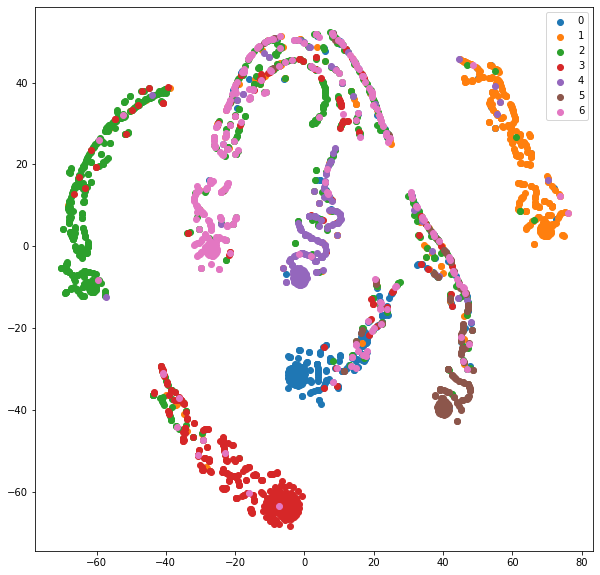

In [9]:
activations = model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

Epoch 1/200
1/1 [==============================] - 1s 901ms/step - loss: 0.1223 - acc: 0.0643 - val_loss: 0.3725 - val_acc: 0.2040
Epoch 2/200
1/1 [==============================] - 0s 108ms/step - loss: 0.1148 - acc: 0.2286 - val_loss: 0.3639 - val_acc: 0.2820
Epoch 3/200
1/1 [==============================] - 0s 107ms/step - loss: 0.1085 - acc: 0.4500 - val_loss: 0.3552 - val_acc: 0.3440
Epoch 4/200
1/1 [==============================] - 0s 108ms/step - loss: 0.1038 - acc: 0.4571 - val_loss: 0.3461 - val_acc: 0.3760
Epoch 5/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0988 - acc: 0.5571 - val_loss: 0.3381 - val_acc: 0.3800
Epoch 6/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0937 - acc: 0.5714 - val_loss: 0.3316 - val_acc: 0.3800
Epoch 7/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0921 - acc: 0.5500 - val_loss: 0.3251 - val_acc: 0.3860
Epoch 8/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0891 - a

1/1 [==============================] - 0s 108ms/step - loss: 0.0596 - acc: 0.8857 - val_loss: 0.1866 - val_acc: 0.8220
Epoch 64/200
1/1 [==============================] - 0s 113ms/step - loss: 0.0567 - acc: 0.9643 - val_loss: 0.1870 - val_acc: 0.8240
Epoch 65/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0558 - acc: 0.9500 - val_loss: 0.1875 - val_acc: 0.8200
Epoch 66/200
1/1 [==============================] - 0s 108ms/step - loss: 0.0560 - acc: 0.9571 - val_loss: 0.1876 - val_acc: 0.8200
Epoch 67/200
1/1 [==============================] - 0s 107ms/step - loss: 0.0543 - acc: 0.9571 - val_loss: 0.1871 - val_acc: 0.8220
Epoch 68/200
1/1 [==============================] - 0s 110ms/step - loss: 0.0583 - acc: 0.9214 - val_loss: 0.1868 - val_acc: 0.8260
Epoch 69/200
1/1 [==============================] - 0s 106ms/step - loss: 0.0580 - acc: 0.9071 - val_loss: 0.1860 - val_acc: 0.8320


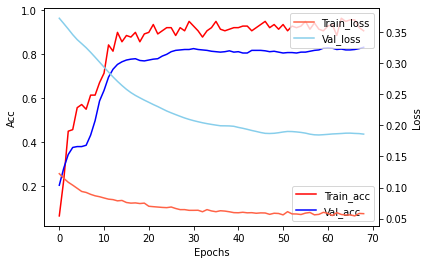

In [2]:
model = GCN(C.GCN_filters, C.dropout)

optimizer = Adam(lr=C.learning_rate)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=C.LOG_PATH)
early_stop = tf.keras.callbacks.EarlyStopping(patience=C.es_patience, restore_best_weights=True)

# callbacks = [tensorboard, early_stop]
callbacks = [early_stop]

validation_data = ([A, X], labels_encoded, val_mask)

history = model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'GCN')

In [3]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([A_te, X_te], batch_size=N)
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> GCN Classification Report:\n{report}')

LOG >>> GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.69      0.79      0.74       113
    Genetic_Algorithms       0.87      0.81      0.84       150
       Neural_Networks       0.86      0.73      0.79       306
 Probabilistic_Methods       0.78      0.78      0.78       167
Reinforcement_Learning       0.76      0.82      0.79        79
         Rule_Learning       0.54      0.79      0.64        62
                Theory       0.59      0.63      0.61       123

              accuracy                           0.76      1000
             macro avg       0.73      0.76      0.74      1000
          weighted avg       0.77      0.76      0.76      1000



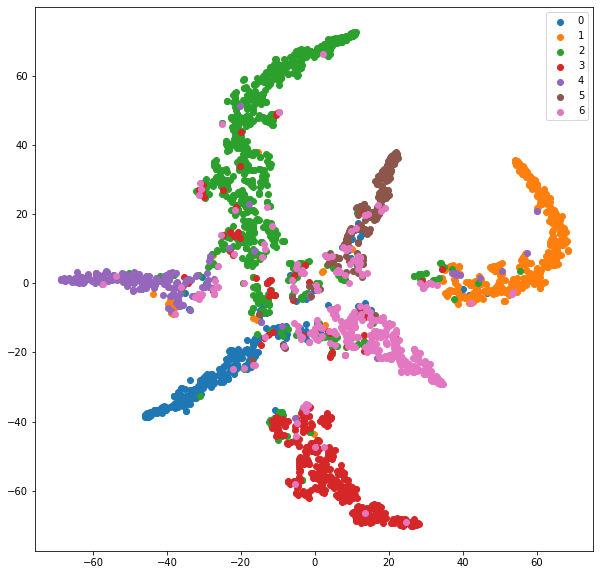

In [4]:
activations = model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)

# Sandbox

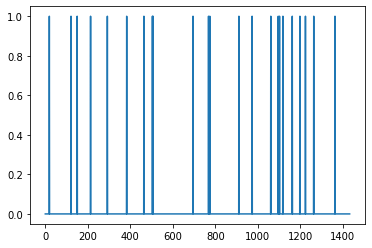

In [5]:
plt.plot(X[0])

In [6]:
class Attention_1(tf.keras.layers.Layer):
    def __init__(self, 
                filters,
                num_head,
                activation=None, 
                bn=False, 
                use_bias=True, 
                kernel_initializer='glorot_uniform', 
                bias_initializer='zeros', 
                kernel_regularizer=None, 
                bias_regularizer=None):
        super(Attention_1, self).__init__()
        self.filters = filters
        self.num_head = num_head
        self.attention_filters = filters // num_head
        self.activation = activation
        self.use_bn = bn
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_initializer = bias_initializer
        self.bias_regularizer = bias_regularizer
        self.BatchNorm = tf.keras.layers.BatchNormalization()
        
    def build(self, input_shape):
        print(f'LOG >>> input shape: {input_shape}\n')
        self.weight = self.add_weight(name='weight',
                                       shape=[input_shape[1][-1], self.attention_filters],
                                       initializer=self.kernel_initializer,
                                       regularizer=self.kernel_regularizer,
                                       trainable=True)
        if self.use_bias:
            self.bias = self.add_weight(name='bias',
                                       shape=self.filters,
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       trainable=True)
        self.correlation_list = []
        for i in range(self.num_head):
            corr = self.add_weight(name=f'correlation_{i}',
                                   shape=[self.attention_filters, self.attention_filters],
                                   initializer=self.kernel_initializer,
                                   regularizer=self.kernel_regularizer,
                                   trainable=True)
            self.correlation_list.append(corr)
        
    def call(self, inputs):
        x = tf.matmul(inputs[0], inputs[1]) # H = AX
        x = tf.matmul(x, self.weight) # HW = AXW
        tf.print(f'LOG >>> output after gcn HW\n{x}\n')
        outputs = []
        for i in range(self.num_head):
            a = self.get_attention(x, i)
            outputs.append(tf.matmul(a, x))
        tf.print(f'LOG >>> output after attention\n{outputs}\n')
        output = tf.concat(outputs, axis=-1)
        tf.print(f'LOG >>> output after concat\n{outputs}\n')
        
        if self.use_bias:
            output = tf.nn.bias_add(output, self.bias)
        if self.use_bn:
            output = self.BatchNorm(output)
        if self.activation:
            output = self.activation(output)
        return [inputs[0], output]
    
    def get_attention(self, hw, i):
        x = tf.matmul(hw, self.correlation_list[i])
        tf.print(f'LOG >>> HWC:\n{x}\n')
        x = tf.matmul(x, tf.transpose(hw))
        tf.print(f'LOG >>> HWC(HW)T:\n{x}\n')
        output = tf.nn.tanh(x)
        tf.print(f'LOG >>> tanh(HWC(HW)T):\n{output}\n')
        return output

LOG >>> input shape: [TensorShape([6, 6]), TensorShape([6, 6])]

LOG >>> output after gcn HW
[[ 0.41806132  0.22264856]
 [-0.8359143  -0.271681  ]
 [ 0.01842493 -0.21173614]
 [-0.7392116  -0.82901096]
 [-0.3686201  -0.0501228 ]
 [ 0.3353495  -0.73921615]]

LOG >>> HWC:
[[ 0.2837728  -0.19277622]
 [-0.53797275  0.36340484]
 [-0.02507449  0.01966151]
 [-0.57560784  0.39619237]
 [-0.22541414  0.15139738]
 [ 0.07194182 -0.0379871 ]]

LOG >>> HWC(HW)T:
[[ 0.07571308 -0.1848361   0.04604619 -0.04995455 -0.09494187  0.23766635]
 [-0.14399403  0.35096896 -0.08685805  0.09640908  0.1800927  -0.44904363]
 [-0.00610507  0.01561847 -0.00462505  0.00223575  0.00825747 -0.02294283]
 [-0.1524277   0.37352088 -0.09449378  0.09704819  0.19232234 -0.4859016 ]
 [-0.06052852  0.14729512 -0.03620954  0.04111867  0.07550372 -0.1875079 ]
 [ 0.02161832 -0.04981683  0.00936876 -0.02168851 -0.02461518  0.05220633]]

LOG >>> tanh(HWC(HW)T):
[[ 0.07556872 -0.18275954  0.04601366 -0.04991303 -0.09465761  0.2332902

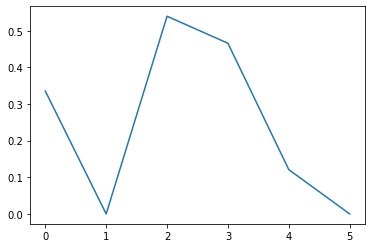

In [7]:
X_t = np.eye(6)
A_t = np.eye(6)

att = Attention_1(6, 3, activation=tf.nn.relu)
temp = att([A_t, X_t])
print(f'LOG >>> gcn weight:\n{att.weight}\n')
print(f'LOG >>> C:\n{att.correlation_list}\n')
print(f'LOG >>> gcn 1st layer:\n{temp[-1]}\n')
plt.plot(temp[-1].numpy()[0])

In [8]:
class Attention(tf.keras.layers.Layer):
    def __init__(self,
                 filters,
                 attn_heads=1,
                 attn_heads_reduction='concat',
                 dropout_rate=0.5,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 attn_kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 attn_kernel_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 attn_kernel_constraint=None,
                 debug=False
                ):
        super(Attention, self).__init__()
        
        self.filters = filters
        self.attn_heads = attn_heads
        self.attn_heads_reduction = attn_heads_reduction
        self.dropout_rate = dropout_rate
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        
        # initializer
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.attn_kernel_initializer = initializers.get(attn_kernel_initializer)
        
        # regularizer
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = regularizers.get(attn_kernel_regularizer)
        
        # constraint
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.attn_kernel_constraint = constraints.get(attn_kernel_constraint)
        
        # params
        self.kernels = []
        self.biases = []
        self.attn_kernels = []
        
        self.debug = debug
        
    def build(self, input_shape):
        F = input_shape[1][1]
        
        for head in range(self.attn_heads):
            kernel = self.add_weight(shape=(F, self.filters),
                                    initializer=self.kernel_initializer,
                                    regularizer=self.kernel_regularizer,
                                    constraint=self.kernel_constraint,
                                    name=f'kernel_{head}'
                                    )
            self.kernels.append(kernel)
            
            if self.use_bias:
                bias = self.add_weight(shape=(self.filters,),
                                      initializer=self.bias_initializer,
                                      regularizer=self.bias_regularizer,
                                      constraint=self.bias_constraint,
                                      name=f'bias_{head}')
                self.biases.append(bias)
            
            attn_kernel_self = self.add_weight(shape=(self.filters, 1),
                                               initializer=self.attn_kernel_initializer,
                                               regularizer=self.attn_kernel_regularizer,
                                               constraint=self.attn_kernel_constraint,
                                               name=f'attn_kernel_self_{head}')
            attn_kernel_neighs = self.add_weight(shape=(self.filters, 1),
                                               initializer=self.attn_kernel_initializer,
                                               regularizer=self.attn_kernel_regularizer,
                                               constraint=self.attn_kernel_constraint,
                                               name=f'attn_kernel_neigh_{head}')
            self.attn_kernels.append([attn_kernel_self, attn_kernel_neighs])
        self.built = True
    
    def call(self, inputs):
        A, X = inputs
        
        outputs = []
        for head in range(self.attn_heads):
            attention_kernel = self.attn_kernels[head]
            
            f = K.dot(X, self.kernels[head])
            if self.debug: tf.print(f'LOG >>> features:\n{f}\n')
            if self.debug: tf.print(f'LOG >>> attention kernel:\n{attention_kernel}\n')
            
            attn_for_self = K.dot(f, attention_kernel[0])
            attn_for_neighs = K.dot(f, attention_kernel[1])
            if self.debug: tf.print(f'LOG >>> attn for self:\n{attn_for_self}\n')
            if self.debug: tf.print(f'LOG >>> attn for neighs:\n{attn_for_neighs}\n')
            
            dense = attn_for_self + K.transpose(attn_for_neighs)
            if self.debug: tf.print(f'LOG >>> dense:\n{dense}\n')
            dense = tf.keras.layers.LeakyReLU(alpha=0.2)(dense)
            dense = K.softmax(dense)
            if self.debug: tf.print(f'LOG >>> softmax:\n{dense}\n')
            
            dropout_attn = tf.keras.layers.Dropout(self.dropout_rate)(dense)
            dropout_feat = tf.keras.layers.Dropout(self.dropout_rate)(f)
            
            node_features = K.dot(dropout_attn, dropout_feat)
            
            if self.use_bias:
                node_features = K.bias_add(node_features, self.biases[head])
            
            outputs.append(node_features)
            
        if self.attn_heads_reduction == 'concat':
            output = K.concatenate(outputs)
        else:
            output = K.mean(K.stack(outputs), axis=0)
            
        output = self.activation(output)
        return output

In [9]:
from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Dropout, LeakyReLU

class GraphAttention(tf.keras.layers.Layer):

    def __init__(self,
                 F_,
                 attn_heads=1,
                 attn_heads_reduction='concat',  # {'concat', 'average'}
                 dropout_rate=0.5,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 attn_kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 attn_kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 attn_kernel_constraint=None,
                 **kwargs):
        if attn_heads_reduction not in {'concat', 'average'}:
            raise ValueError('Possbile reduction methods: concat, average')

        self.F_ = F_  # Number of output features (F' in the paper)
        self.attn_heads = attn_heads  # Number of attention heads (K in the paper)
        self.attn_heads_reduction = attn_heads_reduction  # Eq. 5 and 6 in the paper
        self.dropout_rate = dropout_rate  # Internal dropout rate
        self.activation = activations.get(activation)  # Eq. 4 in the paper
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.attn_kernel_initializer = initializers.get(attn_kernel_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.attn_kernel_regularizer = regularizers.get(attn_kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.attn_kernel_constraint = constraints.get(attn_kernel_constraint)
        self.supports_masking = False

        # Populated by build()
        self.kernels = []       # Layer kernels for attention heads
        self.biases = []        # Layer biases for attention heads
        self.attn_kernels = []  # Attention kernels for attention heads

        if attn_heads_reduction == 'concat':
            # Output will have shape (..., K * F')
            self.output_dim = self.F_ * self.attn_heads
        else:
            # Output will have shape (..., F')
            self.output_dim = self.F_

        super(GraphAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        F = input_shape[0][-1]

        # Initialize weights for each attention head
        for head in range(self.attn_heads):
            # Layer kernel
            kernel = self.add_weight(shape=(F, self.F_),
                                     initializer=self.kernel_initializer,
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint,
                                     name='kernel_{}'.format(head))
            self.kernels.append(kernel)

            # # Layer bias
            if self.use_bias:
                bias = self.add_weight(shape=(self.F_, ),
                                       initializer=self.bias_initializer,
                                       regularizer=self.bias_regularizer,
                                       constraint=self.bias_constraint,
                                       name='bias_{}'.format(head))
                self.biases.append(bias)

            # Attention kernels
            attn_kernel_self = self.add_weight(shape=(self.F_, 1),
                                               initializer=self.attn_kernel_initializer,
                                               regularizer=self.attn_kernel_regularizer,
                                               constraint=self.attn_kernel_constraint,
                                               name='attn_kernel_self_{}'.format(head),)
            attn_kernel_neighs = self.add_weight(shape=(self.F_, 1),
                                                 initializer=self.attn_kernel_initializer,
                                                 regularizer=self.attn_kernel_regularizer,
                                                 constraint=self.attn_kernel_constraint,
                                                 name='attn_kernel_neigh_{}'.format(head))
            self.attn_kernels.append([attn_kernel_self, attn_kernel_neighs])
        self.built = True

    def call(self, inputs):
        X = inputs[0]  # Node features (N x F)
        A = inputs[1]  # Adjacency matrix (N x N)

        outputs = []
        for head in range(self.attn_heads):
            kernel = self.kernels[head]  # W in the paper (F x F')
            attention_kernel = self.attn_kernels[head]  # Attention kernel a in the paper (2F' x 1)

            # Compute inputs to attention network
            features = K.dot(X, kernel)  # (N x F')

            # Compute feature combinations
            # Note: [[a_1], [a_2]]^T [[Wh_i], [Wh_2]] = [a_1]^T [Wh_i] + [a_2]^T [Wh_j]
            attn_for_self = K.dot(features, attention_kernel[0])    # (N x 1), [a_1]^T [Wh_i]
            attn_for_neighs = K.dot(features, attention_kernel[1])  # (N x 1), [a_2]^T [Wh_j]

            # Attention head a(Wh_i, Wh_j) = a^T [[Wh_i], [Wh_j]]
            dense = attn_for_self + K.transpose(attn_for_neighs)  # (N x N) via broadcasting

            # Add nonlinearty
            dense = LeakyReLU(alpha=0.2)(dense)

            # Mask values before activation (Vaswani et al., 2017)
            mask = -10e9 * (1.0 - A)
            dense += mask

            # Apply softmax to get attention coefficients
            dense = K.softmax(dense)  # (N x N)

            # Apply dropout to features and attention coefficients
            dropout_attn = Dropout(self.dropout_rate)(dense)  # (N x N)
            dropout_feat = Dropout(self.dropout_rate)(features)  # (N x F')

            # Linear combination with neighbors' features
            node_features = K.dot(dropout_attn, dropout_feat)  # (N x F')

            if self.use_bias:
                node_features = K.bias_add(node_features, self.biases[head])

            # Add output of attention head to final output
            outputs.append(node_features)

        # Aggregate the heads' output according to the reduction method
        if self.attn_heads_reduction == 'concat':
            output = K.concatenate(outputs)  # (N x KF')
        else:
            output = K.mean(K.stack(outputs), axis=0)  # N x F')

        output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = input_shape[0][0], self.output_dim
        return output_shape

In [11]:
att_1 = Attention(4, debug=True)
att_2 = GraphAttention(4)
X_t = np.eye(6)
A_t = np.eye(6)
output_1 = att_1([A_t, X_t])
output_2 = att_2([X_t, A_t])
print(f'LOG >>> kernel\n{att_1.kernels}\n')
print(f'LOG >>> output\n{output_1}\n')
print(f'LOG >>> output\n{output_2}\n')

LOG >>> features:
[[ 0.40818524 -0.52556103  0.08110571 -0.6381045 ]
 [ 0.3044356  -0.41237378  0.6579772   0.37475133]
 [ 0.0764758  -0.31600904  0.2139095  -0.66242903]
 [-0.08848453  0.3688457   0.24509919  0.0436042 ]
 [-0.1609227  -0.57541937 -0.23177505 -0.35862944]
 [-0.00890023  0.09166116 -0.21571988 -0.7366998 ]]

LOG >>> attention kernel:
ListWrapper([<tf.Variable 'attention_1/attn_kernel_self_0:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.21467805],
       [-0.63477695],
       [ 0.74743986],
       [ 0.34555292]], dtype=float32)>, <tf.Variable 'attention_1/attn_kernel_neigh_0:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.26475835],
       [-0.3255062 ],
       [-0.35063952],
       [ 0.05848563]], dtype=float32)>])

LOG >>> attn for self:
[[ 0.26136523]
 [ 0.9484158 ]
 [ 0.14799313]
 [-0.05486597]
 [ 0.03355302]
 [-0.47590148]]

LOG >>> attn for neighs:
[[ 0.21338503]
 [ 0.00603684]
 [ 0.0093628 ]
 [-0.22687984]
 [ 0.20499177]
 [ 0.00036088]]

LOG >>> dense:
[[ 0.47

In [12]:
class AttentionGCN(tf.keras.Model):
    def __init__(self, dropout, debug=False):
        super(AttentionGCN, self).__init__(name='AttentionGCN')
        
        self.dropout_1 = Dropout(dropout)
        self.attention_1 = Attention(filters=C.GCN_filters,
                                     attn_heads=8,
                                     activation='elu',
                                     kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     attn_kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     debug=debug)
        self.dropout_2 = Dropout(dropout)
        self.attention_2 = Attention(filters=C.num_classes,
                                     attn_heads_reduction='average',
                                     activation='softmax',
                                     kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     attn_kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     debug=debug)
        
    def call(self, input_tensor, training=False):
        A, x = input_tensor
        x = self.dropout_1(x)
        x = self.attention_1([A, x])
        x = self.dropout_2(x)
        x = self.attention_2([A, x])
        return x

In [13]:
class GAT(tf.keras.Model):
    def __init__(self, dropout):
        super(GAT, self).__init__(name='GAT')
        
        self.dropout_1 = Dropout(dropout)
        self.attention_1 = GraphAttention(C.GCN_filters,
                                     attn_heads=8,
                                     activation='elu',
                                     kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     attn_kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     )
        self.dropout_2 = Dropout(dropout)
        self.attention_2 = GraphAttention(C.num_classes,
                                     attn_heads_reduction='average',
                                     activation='softmax',
                                     kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     attn_kernel_regularizer=tf.keras.regularizers.l2(C.l2_reg),
                                     )
        
    def call(self, input_tensor, training=False):
        x, A = input_tensor
        x = self.dropout_1(x)
        x = self.attention_1([x, A])
        x = self.dropout_2(x)
        x = self.attention_2([x, A])
        return x
    
test = GAT(C.dropout)
test([X, A])

<tf.Tensor: shape=(2708, 7), dtype=float32, numpy=
array([[0.14687593, 0.16202396, 0.17291857, ..., 0.09727721, 0.12437623,
        0.12625037],
       [0.1399806 , 0.16016151, 0.14822648, ..., 0.13709843, 0.1511471 ,
        0.11934666],
       [0.15494335, 0.10988621, 0.21865007, ..., 0.13779232, 0.1471989 ,
        0.12654248],
       ...,
       [0.15288994, 0.14897864, 0.14124928, ..., 0.18773864, 0.1052161 ,
        0.11441386],
       [0.17572175, 0.17099853, 0.14640737, ..., 0.11810359, 0.16772284,
        0.11242474],
       [0.13074249, 0.15000428, 0.15066431, ..., 0.14114088, 0.14658126,
        0.13689403]], dtype=float32)>

In [16]:
attention_GCN_model = AttentionGCN(C.dropout)

optimizer = Adam(lr=C.learning_rate)
attention_GCN_model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             weighted_metrics=['acc'])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.2507 - acc: 0.1429 - val_loss: 0.4625 - val_acc: 0.1280
Epoch 2/200
1/1 [==============================] - 0s 484ms/step - loss: 0.2028 - acc: 0.1429 - val_loss: 0.4241 - val_acc: 0.0480
Epoch 3/200
1/1 [==============================] - 0s 489ms/step - loss: 0.1668 - acc: 0.1429 - val_loss: 0.4031 - val_acc: 0.1580
Epoch 4/200
1/1 [==============================] - 0s 483ms/step - loss: 0.1437 - acc: 0.1429 - val_loss: 0.3908 - val_acc: 0.0480
Epoch 5/200
1/1 [==============================] - 0s 488ms/step - loss: 0.1299 - acc: 0.1429 - val_loss: 0.3840 - val_acc: 0.0480
Epoch 6/200
1/1 [==============================] - 0s 487ms/step - loss: 0.1233 - acc: 0.1429 - val_loss: 0.3812 - val_acc: 0.1280
Epoch 7/200
1/1 [==============================] - 0s 484ms/step - loss: 0.1217 - acc: 0.1429 - val_loss: 0.3810 - val_acc: 0.1280
Epoch 8/200
1/1 [==============================] - 0s 487ms/step - loss: 0.1228 - acc:

1/1 [==============================] - 0s 489ms/step - loss: 0.1008 - acc: 0.1429 - val_loss: 0.3595 - val_acc: 0.1280
Epoch 64/200
1/1 [==============================] - 0s 483ms/step - loss: 0.1008 - acc: 0.1429 - val_loss: 0.3595 - val_acc: 0.1280
Epoch 65/200
1/1 [==============================] - 0s 487ms/step - loss: 0.1008 - acc: 0.1429 - val_loss: 0.3594 - val_acc: 0.1580
Epoch 66/200
1/1 [==============================] - 0s 495ms/step - loss: 0.1008 - acc: 0.1429 - val_loss: 0.3594 - val_acc: 0.1580
Epoch 67/200
1/1 [==============================] - 0s 487ms/step - loss: 0.1008 - acc: 0.1429 - val_loss: 0.3594 - val_acc: 0.1580
Epoch 68/200
1/1 [==============================] - 0s 484ms/step - loss: 0.1007 - acc: 0.1429 - val_loss: 0.3594 - val_acc: 0.1580
Epoch 69/200
1/1 [==============================] - 0s 488ms/step - loss: 0.1007 - acc: 0.1429 - val_loss: 0.3594 - val_acc: 0.1580
Epoch 70/200
1/1 [==============================] - 0s 490ms/step - loss: 0.1007 - acc: 0

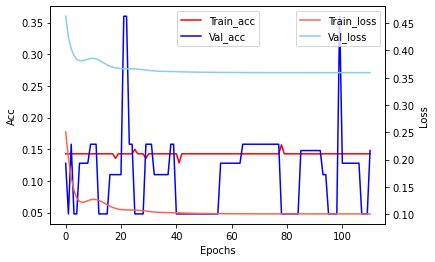

In [17]:
history = attention_GCN_model.fit([A, X],
         labels_encoded,
         sample_weight=train_mask,
         epochs=C.epochs,
         batch_size=N,
         validation_data=validation_data,
         shuffle=False,
         callbacks=callbacks)

draw_history(history, 'Attention GCN', issave=False)

In [18]:
X_te = X[test_mask]
A_te = A[test_mask, :][:, test_mask]
y_te = labels_encoded[test_mask]

y_pred = attention_GCN_model.predict([A_te, X_te], batch_size=N)
# y_pred = attention_GCN_model.predict([A, X], batch_size=N)[test_mask]
report = classification_report(np.argmax(y_te, axis=1),
                              np.argmax(y_pred, axis=1),
                              target_names=classes)
print(f'LOG >>> Attention GCN Classification Report:\n{report}')

LOG >>> Attention GCN Classification Report:
                        precision    recall  f1-score   support

            Case_Based       0.00      0.00      0.00       113
    Genetic_Algorithms       0.00      0.00      0.00       150
       Neural_Networks       0.00      0.00      0.00       306
 Probabilistic_Methods       0.00      0.00      0.00       167
Reinforcement_Learning       0.00      0.00      0.00        79
         Rule_Learning       0.00      0.00      0.00        62
                Theory       0.12      1.00      0.22       123

              accuracy                           0.12      1000
             macro avg       0.02      0.14      0.03      1000
          weighted avg       0.02      0.12      0.03      1000



/home/sungjin/anaconda3/envs/GCN/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


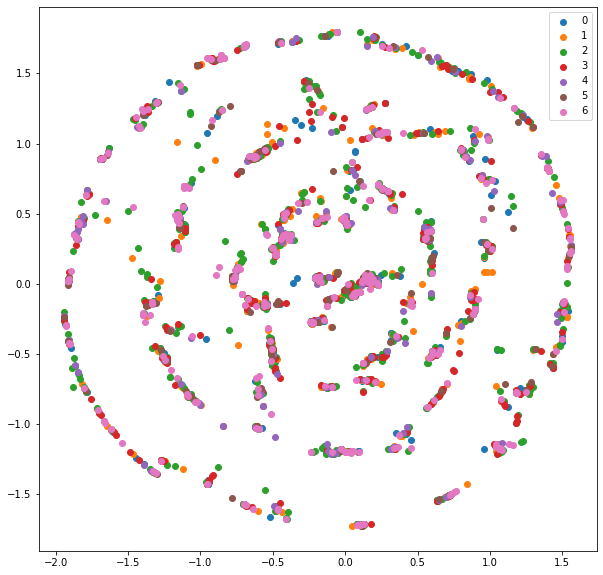

In [19]:
activations = attention_GCN_model.predict([A, X], batch_size=N)

x_tsne = TSNE(n_components=2).fit_transform(activations)

plot_tSNE(labels_encoded, x_tsne)